In [1]:
# Required libraries :
# tensorflow
# yfinance
# matplotlib
# pandas
# numpy

Install all the above mentioned libraries using <b>'pip'</b>. <br>
For example to install <b>yfinance</b>, run : `pip install yfinance`    

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import pickle

### Deciding two things:
1. the <b>dates</b> over which we want to collect the data
2. the <b>stock symbol</b> for which we want to train the model

In [3]:
# we chose the 'ITC' stock over the NSE market over a period of 10 years
start = '2012-01-01'
end = '2022-12-21'
stock = 'ITC.NS' 

In [4]:
#downloading the data
data = yf.download(stock,start,end)

[*********************100%%**********************]  1 of 1 completed


### EDA

In [5]:
# create a new pandas dataframe using the data received from yfinance
prices = pd.DataFrame(data)
prices.sample(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-03-07,264.299988,265.000000,261.149994,264.250000,211.705063,6917130
2017-08-16,272.000000,281.750000,271.350006,279.200012,227.061249,18692336
2013-02-26,195.333328,198.899994,192.533340,193.899994,146.545807,10622350
2014-02-18,213.333328,214.366669,210.766663,211.266663,162.072769,5848975
2019-11-01,259.350006,263.000000,258.750000,261.299988,220.710419,12571588
2014-08-22,230.833328,231.899994,227.699997,229.100006,178.942810,6859716
2015-05-05,219.066666,219.333328,215.733337,217.500000,169.882416,13458043
2019-09-23,250.000000,260.500000,249.899994,254.850006,215.262375,52040316
2016-07-29,254.199997,256.500000,251.399994,252.449997,202.251434,12129756


In [6]:
#checking null values
prices.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
prices.shape

(2705, 6)

In [8]:
#add a new row to indicate the indeces
prices.reset_index(inplace=True)

In [9]:
prices.sample(10)

,Date,Open,High,Low,Close,Adj Close,Volume
409,2013-08-28,197.333328,203.199997,190.133331,198.800003,152.509003,20711271
648,2014-08-18,236.399994,236.666672,231.033340,233.766663,182.587799,6957297
439,2013-10-11,232.399994,233.300003,227.133331,228.133331,175.012009,5345368
1243,2017-01-20,254.250000,256.299988,253.699997,255.399994,204.614853,10843902
1722,2018-12-31,282.799988,283.850006,281.100006,281.649994,233.427551,5452405
2421,2021-10-29,225.000000,228.250000,222.300003,223.199997,208.564468,26642108
2146,2020-09-21,180.000000,180.600006,175.050003,175.750000,156.082535,23891325
110,2012-06-12,158.100006,162.833328,157.033340,162.033340,122.461594,6512775
7,2012-01-11,136.766663,137.066666,135.000000,135.533340,100.506386,8114019
2211,2020-12-23,203.000000,208.250000,202.000000,207.750000,184.501572,23695667


In [10]:
prices.shape

(2705, 7)

as we can see, a new column has been added and the <b>shape[1]</b> increased from *6* to *7*

### Prediction strategy
Our model will be trained to predict the price of a particular stock using the <b>moving average</b> of the same for the past *100* days.<br>
This implies that the fluctuations in the last *100* days of the price will be studied and the price for the *101*st day will be predicted using that.

### Plotting the moving averages

In [11]:
#calculating the moving average using rolling() function and finding the mean over a period of 100 days (window size =100)
ma_100=prices.Close.rolling(100).mean()

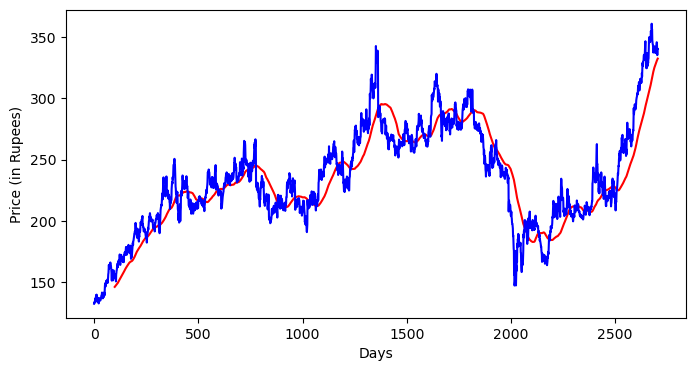

In [12]:
plt.figure(figsize=(8,4))
plt.plot(ma_100,'r')
plt.plot(prices['Close'],'b')
plt.ylabel("Price (in Rupees)")
plt.xlabel("Days")
plt.show()

In [13]:
#Calculating the moving average of 200 days
ma_200= prices['Close'].rolling(200).mean()

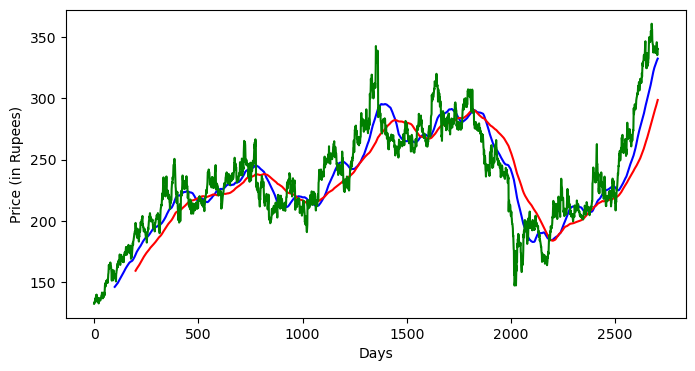

In [14]:
plt.figure(figsize=(8,4))
plt.plot(ma_100,'b')
plt.plot(ma_200,'r')
plt.plot(prices['Close'],'g')
plt.ylabel("Price (in Rupees)")
plt.xlabel("Days")
plt.show()

### Splitting the dataset into training and testing

In [15]:
#adding the first 80% of the data values into training set and the rest 20% into test set
data_train = prices['Close'][0:int(len(prices)*0.80)]
data_test = prices['Close'][int(len(prices)*0.80):len(prices)]

In [16]:
#viewing the first 5 values of the 
data_train.head()

0    132.433334
1    133.566666
2    133.033340
3    133.199997
4    134.733337
Name: Close, dtype: float64

In [17]:
data_test.head()

2164    165.699997
2165    168.250000
2166    167.449997
2167    167.649994
2168    168.550003
Name: Close, dtype: float64

In [18]:
print(data_train.shape,data_test.shape)

(2164,) (541,)


In [19]:
#scaling down the training and test set values to lie b/w 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

In [20]:
#reshaping the training dataset to form a 2d array
data_train = np.array(data_train)
data_train=data_train.reshape(-1,1)
data_train

array([[132.43333435],
       [133.56666565],
       [133.03334045],
       ...,
       [170.1499939 ],
       [167.80000305],
       [165.05000305]])

In [21]:
data_train_scale = scaler.fit_transform(data_train)

In [22]:
data_train_scale

array([[0.        ],
       [0.0053951 ],
       [0.00285627],
       ...,
       [0.17954614],
       [0.16835926],
       [0.15526818]])

In [23]:
data_test = np.array(data_test)
data_test = data_test.reshape(-1,1)
data_test[:10]

array([[165.69999695],
       [168.25      ],
       [167.44999695],
       [167.6499939 ],
       [168.55000305],
       [170.75      ],
       [168.55000305],
       [167.19999695],
       [165.5       ],
       [163.8500061 ]])

In [24]:
data_test_scale = scaler.fit_transform(data_test)

In [25]:
data_test_scale[10:20]

array([[0.00711198],
       [0.014732  ],
       [0.03175006],
       [0.03022604],
       [0.05537208],
       [0.05130805],
       [0.04546607],
       [0.07366015],
       [0.1089662 ],
       [0.12268221]])

we take the data from past 100 days each time to predict the price of stock for the 101th day

In [26]:
x=[]
y=[]
for i in range(100,data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])

In [27]:
#converting the input features into numpy arrays
x= np.array(x)
y= np.array(y)

### Model Creation

A <b>Sequential</b> object can be used to group several layers of a neural network and group them together instead of individually creating every single layer and implementing it in the code.

In [28]:
#Creating a Sequential object
model = Sequential()
model.add(LSTM(units=50, activation='relu',return_sequences= True, input_shape=((x.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu',return_sequences= True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu',return_sequences= True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [29]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
model.fit(x,y,epochs=50,batch_size=32, verbose=1)

Epoch 1/50
65/65 [==============================] - 13s 138ms/step - loss: 0.0479
Epoch 2/50
65/65 [==============================] - 9s 136ms/step - loss: 0.0117
Epoch 3/50
65/65 [==============================] - 9s 136ms/step - loss: 0.0101
Epoch 4/50
65/65 [==============================] - 9s 135ms/step - loss: 0.0091
Epoch 5/50
65/65 [==============================] - 9s 132ms/step - loss: 0.0093
Epoch 6/50
65/65 [==============================] - 9s 133ms/step - loss: 0.0084
Epoch 7/50
65/65 [==============================] - 9s 131ms/step - loss: 0.0080
Epoch 8/50
65/65 [==============================] - 9s 131ms/step - loss: 0.0080
Epoch 9/50
65/65 [==============================] - 8s 130ms/step - loss: 0.0070
Epoch 10/50
65/65 [==============================] - 9s 133ms/step - loss: 0.0060
Epoch 11/50
65/65 [==============================] - 9s 134ms/step - loss: 0.0064
Epoch 12/50
65/65 [==============================] - 9s 134ms/step - loss: 0.0057
Epoch 13/50
65/65 [=====

In [31]:
#model's summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

### Evaluation of model

We predict the closing price of a stock for nth day using the data for the last n-100 days. So we need to add the last *100* rows from the training dataset into the test dataset to evaluate the values after that and so on and so forth

In [32]:
#converting np array into pd dataframe and finding the last 100 rows
last_100_days = (pd.DataFrame(data_train_scale)).tail(100)

In [33]:
#concatenating the 'last 100 days' rows with the data_test_scale dataset
data_test_scale = pd.concat([last_100_days,pd.DataFrame(data_test_scale)],ignore_index=True)

In [34]:
data_test_scale= np.array(data_test_scale).reshape(-1,1)
data_test_scale[:10]

array([[0.27713421],
       [0.30902891],
       [0.32426215],
       [0.30855284],
       [0.30593461],
       [0.32235795],
       [0.32164392],
       [0.31045697],
       [0.31450333],
       [0.31712156]])

In [35]:
#appending the last 100 days data into a list to feed to the model
x=[]
y=[]
for i in range(100,data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])

In [36]:
# converting the lists into numpy arrays
x= np.array(x)
y= np.array(y)

In [37]:
#feeding the data into the model to make predictions
y_predicted = model.predict(x)

17/17 [==============================] - 1s 46ms/step


In [38]:
#printing the first 10 predictions
y_predicted[:10]

array([[0.16908023],
       [0.16244355],
       [0.14858626],
       [0.129011  ],
       [0.10808507],
       [0.09054276],
       [0.07957515],
       [0.07522371],
       [0.0753558 ],
       [0.07729244]], dtype=float32)

In [39]:
#converting the predicted values back to the original prices
y_predicted=y_predicted*(1/scaler.scale_)

In [40]:
#printing the first 10 predicted values
y_predicted[:10]

array([[33.28344384],
       [31.9770135 ],
       [29.24920585],
       [25.39581715],
       [21.27654592],
       [17.82334354],
       [15.664369  ],
       [14.80778858],
       [14.8337893 ],
       [15.21501774]])

In [41]:
#converting back the actual values
y = y*(1/scaler.scale_)

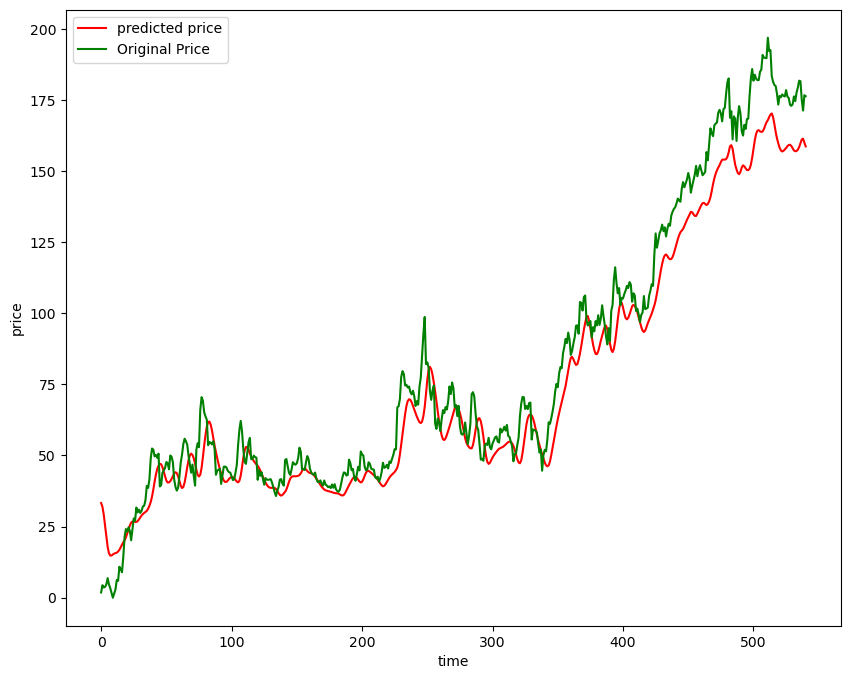

In [42]:
#plotting the predicted and actual values to see how good the model is
plt.figure(figsize=(10,8))
plt.plot(y_predicted,'r',label='predicted price')
plt.plot(y,'g',label = 'Original Price')
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.show()

In [45]:
filename = 'Model.pkl'
pickle.dump(model,open(filename,'wb'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9